In [163]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Lambda, Concatenate
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [131]:
class f_model:
    def __init__(self, theta_range, x_range, N_x, dx):
        #Theta_range is the span of parameters a, b and c. 
        #x_range is the (x_start_x_stop) values that are allowed for x to start 
        #N_x is how many points in x_range that will be trained on.
        self.theta_range = theta_range 
        self.x_range = x_range 
        self.N_x = N_x 
        self.dx = dx
        
    def give_rand_theta(self): 
        theta_rand = [np.random.uniform(th[0], th[1]) for th in self.theta_range]
        self.theta = theta_rand
        return theta_rand 
    
    def calc_output(self): 
        y = self.give_rand_theta() 
        x_start = np.random.uniform(self.x_range[0], self.x_range[1]) 
        x = np.array([x_start + i*dx for i in range(self.N_x)])
        return np.array([x, self.f(x)]), y
    
    def f(self, x): 
        return self.theta[0]*x**2 + self.theta[1]*x + self.theta[2]
    

In [132]:
theta_range = [(-5, 5), (-5, 5), (-10, 10)]
x_range = (-10, 10)
dx = 0.5 
N_x = 10 

X_NN = []
y_NN = [] 

N_sim = 100000 
mod = f_model(theta_range, x_range, N_x, dx)
for i in range(N_sim): 
    X, y = mod.calc_output() #Returns X as shape (N_vars, N_steps)
    X_NN.append(X.T) 
    y_NN.append(y)
    
X_NN = np.array(X_NN) 
y_NN = np.array(y_NN)

In [156]:
class Scaler_class: 
    def __init__(self): 
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
    def fit(self, X_NN, y_NN): #Data shape = (N_sim, N_steps, N_var)
        self.y_scaler = self.y_scaler.fit(y_NN)
        
        X_NN_temp = X_NN.reshape(-1, X_NN.shape[-1])
        self.x_scaler = self.X_scaler.fit(X_NN_temp)
        X_NN_temp = self.X_scaler.transform(X_NN_temp).reshape(X_NN.shape)
                    
            
        return X_NN_temp, self.y_scaler.transform(y_NN)
    
    def transform(self, X_NN, y_NN): 
        X_NN_temp = X_NN.reshape(-1, X_NN.shape[-1])
        X_NN_temp = self.X_scaler.transform(X_NN_temp).reshape(X_NN.shape)
            
        return X_NN_temp, self.y_scaler.transform(y_NN)
            

In [157]:
Scaler = Scaler_class()
X_sc, y_sc = Scaler.fit(X_NN, y_NN)
X_train, X_test, y_train, y_test  = train_test_split(X_sc, y_sc, test_size=0.2)

In [149]:
N_h1 = 200
N_h2 = 200

N_vars = 2
N_seq = N_x
N_out = 3

#Functional API model 
inputs = keras.Input(shape=(N_seq, N_vars), name="Variables")
NN = Dense(N_h1, activation='relu', name="NN1")(inputs)
NN = Flatten(name="Flatten_Layer1")(NN)
NN = Dense(N_h2, activation='relu', name="NN2")(NN)

output = Dense(N_out, name="Out1")(NN)

model = keras.Model(inputs=inputs, outputs=output, name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Variables (InputLayer)       [(None, 10, 2)]           0         
_________________________________________________________________
NN1 (Dense)                  (None, 10, 200)           600       
_________________________________________________________________
Flatten_Layer1 (Flatten)     (None, 2000)              0         
_________________________________________________________________
NN2 (Dense)                  (None, 200)               400200    
_________________________________________________________________
Out1 (Dense)                 (None, 3)                 603       
Total params: 401,403
Trainable params: 401,403
Non-trainable params: 0
_________________________________________________________________


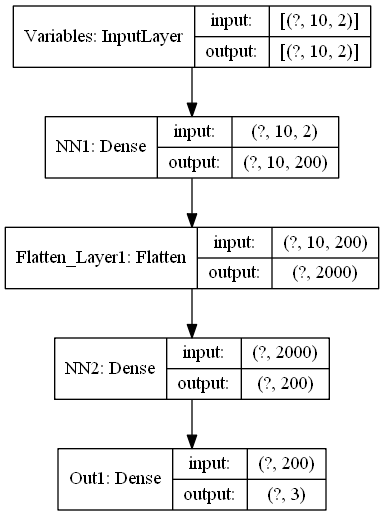

In [150]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [151]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, 
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/20
2500/2500 [==============================] - 37s 15ms/step - loss: 0.0606 - accuracy: 0.5110 - val_loss: 0.0540 - val_accuracy: 0.5419
Epoch 2/20
2500/2500 [==============================] - 52s 21ms/step - loss: 0.0521 - accuracy: 0.5683 - val_loss: 0.0460 - val_accuracy: 0.6018
Epoch 3/20
2500/2500 [==============================] - 39s 16ms/step - loss: 0.0405 - accuracy: 0.6428 - val_loss: 0.0335 - val_accuracy: 0.6944
Epoch 4/20
2500/2500 [==============================] - 39s 16ms/step - loss: 0.0292 - accuracy: 0.7084 - val_loss: 0.0251 - val_accuracy: 0.7474
Epoch 5/20
2500/2500 [==============================] - 41s 16ms/step - loss: 0.0248 - accuracy: 0.7380 - val_loss: 0.0224 - val_accuracy: 0.7556
Epoch 6/20
2500/2500 [==============================] - 40s 16ms/step - loss: 0.0233 - accuracy: 0.7489 - val_loss: 0.0232 - val_accuracy: 0.7344
Epoch 7/20
2500/2500 [==============================] - 39s 16ms/step - loss: 0.0222 - accuracy: 0.7543 - val_loss: 0.0204 -

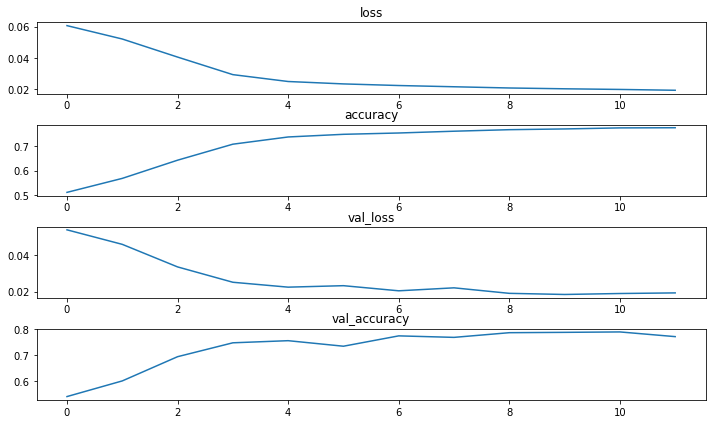

In [152]:
hist = history.history 
fig, axes = plt.subplots(len(hist), 1)
for el, ax in zip(hist, axes): 
    ax.plot(hist[el])
    ax.set_title(el)
    
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout(h_pad=-0.2)
plt.show()  

In [158]:
[x, f], theta = mod.calc_output()

In [159]:
X = np.array([x, f]).T.reshape(1, 10, 2)

In [161]:
X_pred, y_res = Scaler.transform(X, [theta])

print(f"Predicted is {model.predict(X_pred)} while real is {y_res}")

Predicted is [[0.26025844 0.2892427  0.60391754]] while real is [[0.2567822  0.26481425 0.85379906]]


In [192]:
N_h1 = 400
N_h2 = 300

N_vars = 2
N_seq = N_x
N_out = 3

#Functional API model 
inputs = keras.Input(shape=(N_seq, N_vars), name="Variables")
#input1 = Flatten(name="Flattening")(inputs)
x_n = tf.split(inputs, num_or_size_splits=N_seq//5, axis=1, name="Split1") 
NN1 = [Dense(N_h1, activation='relu', name=f"NN1_x{i+1}")(x1) for i, x1 in enumerate(x_n)]
NN = Concatenate(axis=1, name="Out2")(NN1)
NN = Dense(N_h2, activation='relu', name="NN2")(NN)
NN = Flatten()(NN)
output = Dense(N_out, name="Out1")(NN)

model = keras.Model(inputs=inputs, outputs=output, name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Variables (InputLayer)          [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Split1_13 (TensorFl [(None, 5, 2), (None 0           Variables[0][0]                  
__________________________________________________________________________________________________
NN1_x1 (Dense)                  (None, 5, 400)       1200        tf_op_layer_Split1_13[0][0]      
__________________________________________________________________________________________________
NN1_x2 (Dense)                  (None, 5, 400)       1200        tf_op_layer_Split1_13[0][1]      
_______________________________________________________________________________________

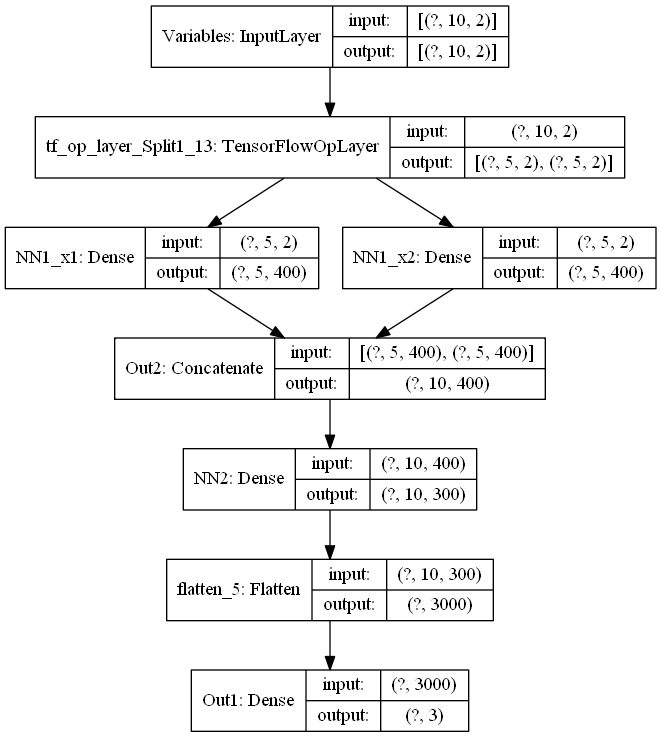

In [193]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [194]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, 
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/20
1275/2500 [==============>...............] - ETA: 14s - loss: 0.0649 - accuracy: 0.4866

KeyboardInterrupt: 

In [ ]:
hist = history.history 
fig, axes = plt.subplots(len(hist), 1)
for el, ax in zip(hist, axes): 
    ax.plot(hist[el])
    ax.set_title(el)
    
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout(h_pad=-0.2)
plt.show()  